In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.blr import BayesLinearRegressor, eenn_bayes_intervals
from avcs.regression import parallel_eenn_avcs_regression, running_intersection
from avcs.metrics import marginal_coverage, consistency

from matplotlib.lines import Line2D
import utils.plotting_style

In [2]:
# Data params
Y_MIN = 0.
Y_MAX = 5.

# Model params
MODEL_TYPE = 'albert_large'

# AVCS params
ALPHA = 0.05
S = 1

In [3]:
h_arr_test = torch.load(f'data/albert/{MODEL_TYPE}/h_test.pt', map_location=torch.device('cpu'))
targets_test = torch.load(f'data/albert/{MODEL_TYPE}/targets_test.pt', map_location=torch.device('cpu'))
preds_test = torch.load(f'data/albert/{MODEL_TYPE}/logits_test.pt', map_location=torch.device('cpu'))
preds_test = preds_test.squeeze()

h_arr_dev = torch.load(f'data/albert/{MODEL_TYPE}/h_dev.pt', map_location=torch.device('cpu'))
targets_dev = torch.load(f'data/albert/{MODEL_TYPE}/targets_dev.pt', map_location=torch.device('cpu'))
preds_dev = torch.load(f'data/albert/{MODEL_TYPE}/logits_dev.pt', map_location=torch.device('cpu'))
preds_dev = preds_dev.squeeze()

L_test, N_test, H_test = h_arr_test.shape
L_dev, N_dev, H_dev = h_arr_dev.shape

In [4]:
BLRs = []
for l in range(L_test):
    BLR_d = BayesLinearRegressor(model=None)
    BLR_d.fit(h_arr_dev[l], targets_dev.reshape(-1, 1).numpy())
    print(BLR_d.sigma_likelihood)
    BLRs.append(BLR_d)

1.405257490541741
0.8632290558172749
0.7645149945919076
0.7395760259141468
0.6954734553561609
0.6672025383499242
0.6538816284838427
0.6402090011507712
0.6282144688999803
0.6255685884839376
0.6165519558184929
0.6126799557094663
0.6087596116703538
0.6032270791806079
0.6056156601795679
0.5990679996401642
0.6011516712413905
0.6003744919999162
0.6003534133626974
0.5967849717941237
0.597134134837986
0.5979679999504608
0.6013829892076017
0.5990267424420502


In [5]:
c_avcs, epistem_uncer, preds = parallel_eenn_avcs_regression(x_star=h_arr_test, BLR_models=BLRs, alpha=ALPHA, S=S)
c_avcs = [running_intersection(C) for C in c_avcs]
c_bayes = eenn_bayes_intervals(x_star=h_arr_test, BLR_models=BLRs)
c_bayes_intersect = [running_intersection(C) for C in c_bayes]

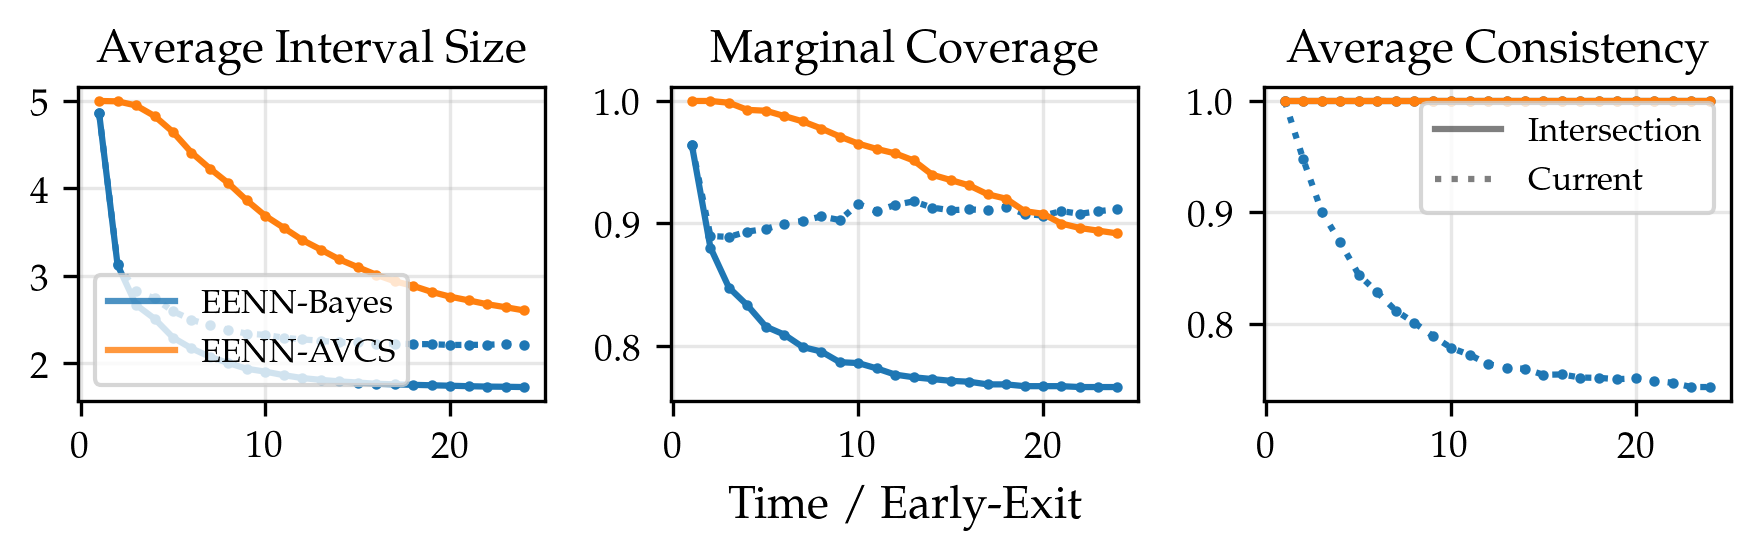

In [6]:
COLOR_DICT = {'AVCS': 'tab:orange', 'BLR': 'tab:blue', 
              'AVCS-intersect': 'tab:orange', 'BLR-intersect': 'tab:blue',}
LS_DICT = {'AVCS': 'dotted', 'BLR': 'dotted', 'AVCS-intersect': '-', 'BLR-intersect': '-',}
EXITS = [l + 1 for l in range(L_test)]
fig, ax = plt.subplots(1, 3, figsize=(6, 2))

LW = 1.5
MS = 1.5

for label, intervals in zip(['BLR', 'BLR-intersect', 'AVCS-intersect'], [c_bayes, c_bayes_intersect, c_avcs]):

    clipped_sizes = np.mean([np.array([min(c[l][1], Y_MAX) - max(c[l][0], Y_MIN) for c in intervals]) for l in range(L_test)], axis=1)
    coverage = marginal_coverage(targets_test, intervals)
    consistency_arr = [1.] + list(np.mean(consistency(intervals), axis=0))
    
    for i, (plot_type, data) in enumerate(zip(['Average Interval Size', 'Marginal Coverage', 'Average Consistency'],
                               [clipped_sizes, coverage, consistency_arr])):
        
        ax[i].plot(EXITS, data, marker='o', color=COLOR_DICT[label], linestyle=LS_DICT[label], label=label, ms=MS, lw=LW)
        ax[i].set_title(plot_type)


ax[1].set_xlabel('Time / Early-Exit')


lines1 = [
    Line2D([0], [0], color='black', lw=LW, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=LW, linestyle='dotted', alpha=0.5),
]
labels1 = ["Intersection", 'Current']
lines2 = [Line2D([0], [0], color=color, lw=LW, linestyle='-', alpha=0.8) for label, color in COLOR_DICT.items() if 'intersect' not in label][::-1]
labels2 = ['EENN-Bayes', 'EENN-AVCS']
legend1 = ax[2].legend(lines1, labels1,  fontsize=8)
legend2 = ax[0].legend(lines2, labels2, loc='lower left', fontsize=8)

plt.tight_layout()
plt.show()